<a href="https://colab.research.google.com/github/Ayeman985/Sentiment-Analysis---Major-Project/blob/main/Major_Project_ML_September_(Ayeman).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install vaderSentiment

In [2]:
!pip install streamlit

In [3]:
import streamlit as st

In [4]:
#importing the libraries

import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import re
import textblob

from textblob import TextBlob,Word
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

In [5]:
df = st.cache(pd.read_csv)("Tweets(2).csv",encoding='ISO-8859-1')
#df = pd.read_csv('Tweets(2).csv',encoding='ISO-8859-1')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
!pip install flair

In [7]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [8]:
import pandas as pd

col_names = ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone']
data_path = 'Tweets(2).csv'

tweet_data = pd.read_csv(data_path, header=None, names=col_names, encoding="ISO-8859-1").sample(frac=1) # .sample(frac=1) shuffles the data
tweet_data = tweet_data[['airline_sentiment', 'text']] # Disregard other columns
print(tweet_data.head())

     airline_sentiment                                               text
626            neutral  @united So do I need to book two one ways in o...
3891          negative  @united Couldn't use the confirmed upgd cert y...
4615          positive  @SouthwestAir What can we do to bring you back...
8999           neutral  @USAirways did you know that suicide is the se...
8081          negative  @JetBlue we've been on the runway for over an ...


In [9]:

import re

allowed_chars = ' AaBbCcDdEeFfGgHhIiJjKkLlMmNnOoPpQqRrSsTtUuVvWwXxYyZz0123456789~`!@#$%^&*()-=_+[]{}|;:",./<>?'
punct = '!?,.@#'
maxlen = 280

def preprocess(text):
    return ''.join([' ' + char + ' ' if char in punct else char for char in [char for char in re.sub(r'http\S+', 'http', text, flags=re.MULTILINE) if char in allowed_chars]])[:maxlen]


In [10]:
tweet_data['text'] = tweet_data['text'].apply(preprocess)

In [11]:
tweet_data['airline_sentiment'] = '' + tweet_data['airline_sentiment'].astype(str)

2020-10-25 19:11:02.794 INFO    numexpr.utils: NumExpr defaulting to 2 threads.


In [12]:
from flair.data import Sentence
from flair.models import TextClassifier

2020-10-25 19:11:06.442 INFO    summarizer.preprocessing.cleaner: 'pattern' package not found; tag filters are not available for English


In [13]:

import os

# Create directory for saving data if it does not already exist
data_dir = '/content/processed-data'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

# Save a percentage of the data (you could also only load a fraction of the data instead)
amount = 0.125

tweet_data.iloc[0:int(len(tweet_data)*0.8*amount)].to_csv(data_dir + '/Tweets(2).csv', sep='\t', index=False, header=False)
tweet_data.iloc[int(len(tweet_data)*0.8*amount):int(len(tweet_data)*0.9*amount)].to_csv(data_dir + '/test.csv', sep='\t', index=False, header=False)
tweet_data.iloc[int(len(tweet_data)*0.9*amount):int(len(tweet_data)*1.0*amount)].to_csv(data_dir + '/dev.csv', sep='\t', index=False, header=False)


In [14]:
# Set page title
st.title('Twitter Sentiment Analysis')


In [15]:
from flair.embeddings import WordEmbeddings, FlairEmbeddings

word_embeddings = [WordEmbeddings('glove'),
                   FlairEmbeddings('news-forward'),
                   FlairEmbeddings('news-backward')]
                  

2020-10-25 19:11:06.552 INFO    gensim.utils: loading Word2VecKeyedVectors object from /root/.flair/embeddings/glove.gensim
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-10-25 19:11:08.097 INFO    gensim.utils: loading vectors from /root/.flair/embeddings/glove.gensim.vectors.npy with mmap=None
2020-10-25 19:11:08.201 INFO    gensim.utils: setting ignored attribute vectors_norm to None
2020-10-25 19:11:08.202 INFO    gensim.utils: loaded /root/.flair/embeddings/glove.gensim


In [16]:
from flair.embeddings import DocumentRNNEmbeddings

document_embeddings = DocumentRNNEmbeddings(word_embeddings, hidden_size=512, reproject_words=True, reproject_words_dimension=256)


In [17]:
import flair.datasets
corpus = flair.datasets.UD_ENGLISH()

2020-10-25 19:11:08,967 Reading data from /root/.flair/datasets/ud_english
2020-10-25 19:11:08,968 Train: /root/.flair/datasets/ud_english/en_ewt-ud-train.conllu
2020-10-25 19:11:08,969 Dev: /root/.flair/datasets/ud_english/en_ewt-ud-dev.conllu
2020-10-25 19:11:08,970 Test: /root/.flair/datasets/ud_english/en_ewt-ud-test.conllu


In [18]:

from flair.data_fetcher import NLPTaskDataFetcher
from pathlib import Path

#corpus = NLPTaskDataFetcher.load_classification_corpus(Path(/content/Tweets(2).csv), test_file='test.csv', dev_file='dev.csv', train_file='train.csv')
label_dict = corpus.make_label_dictionary()


2020-10-25 19:11:17,999 Computing label dictionary. Progress:


100%|██████████| 14620/14620 [00:01<00:00, 12149.41it/s]

2020-10-25 19:11:19,208 [b'Al', b'PROPN', b'NNP', b'root', b'Sing', b'-', b'PUNCT', b'HYPH', b'punct', b'Zaman', b'flat', b':', b'american', b'ADJ', b'JJ', b'amod', b'Pos', b'force', b'NOUN', b'NNS', b'nsubj', b'Plur', b'kill', b'VERB', b'VBD', b'parataxis', b'Ind', b'Past', b'Fin', b'Shaikh', b'obj', b'Abdullah', b'al', b'Ani', b',', b'the', b'DET', b'DT', b'det', b'Def', b'Art', b'preacher', b'NN', b'appos', b'at', b'ADP', b'IN', b'case', b'mosque', b'obl', b'in', b'town', b'nmod', b'of', b'Qaim', b'near', b'syrian', b'border', b'.', b'[', b'-LRB-', b'this', b'Dem', b'killing', b'a', b'respected', b'cleric', b'will', b'AUX', b'MD', b'aux', b'be', b'VB', b'Inf', b'cause', b'VBG', b'Ger', b'we', b'PRON', b'PRP', b'iobj', b'Acc', b'1', b'Prs', b'trouble', b'for', b'year', b'to', b'PART', b'TO', b'mark', b'come', b'acl', b']', b'-RRB-', b'DPA', b'iraqi', b'authority', b'announce', b'that', b'SCONJ', b'they', b'Nom', b'3', b'have', b'bust', b'VBN', b'ccomp', b'Part', b'up', b'RP', b'compo

In [19]:
from flair.models import TextClassifier

classifier = TextClassifier(document_embeddings, label_dictionary=label_dict)

In [20]:
from flair.trainers import ModelTrainer

trainer = ModelTrainer(classifier, corpus)

In [21]:
df.shape

(14640, 15)

In [22]:
df.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


In [23]:
df.tail(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)
14639,569587140490866689,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know h...,NaN,2015-02-22 11:58:51 -0800,"dallas, TX",NaN


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [25]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [26]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [27]:
((df.isnull() | df.isna()).sum() * 100 / df.index.size).round(2)

tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64

In [28]:
del df['tweet_coord']
del df['airline_sentiment_gold']
del df['negativereason_gold']
del df['tweet_id']
del df['retweet_count']
df.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,text,tweet_created,tweet_location,user_timezone
0,neutral,1.0000,NaN,NaN,Virgin America,cairdin,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,positive,0.3486,NaN,0.0000,Virgin America,jnardino,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [29]:
for attribute in list((df.describe(include=np.object)).keys()):
    print('')
    print(f'Analyzing the attribute "{attribute}"')
    print(df[attribute].value_counts())
    print(f'Actual length of dataframe {len(df)}')
    print('')
    print('*'*50)


Analyzing the attribute "airline_sentiment"
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64
Actual length of dataframe 14640

**************************************************

Analyzing the attribute "negativereason"
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64
Actual length of dataframe 14640

**************************************************

Analyzing the attribute "airline"
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64
Actual length of dataframe 14640

************************

In [30]:
s=df['user_timezone'].mode()
df['user_timezone'].fillna(value=s, inplace=True)

In [31]:
t=df['tweet_location'].mode()
df['tweet_location'].fillna(value=t[0], inplace=True)

In [32]:
df['negativereason'].fillna(value='Nan',inplace=True)
df['negativereason_confidence'].fillna(value='Nan', inplace=True)

In [33]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [34]:
dff = df.groupby(["airline", "airline_sentiment" ]).count()['name']
dff['American']

airline_sentiment
negative    1960
neutral      463
positive     336
Name: name, dtype: int64

In [35]:
airlines=df.airline.unique()
positive_percentage = []
negative_percentage = []
neutral_percentage = []
for i in airlines:
    positive_percentage.append((dff[i].positive/dff[i].sum())*100)
    negative_percentage.append((dff[i].negative/dff[i].sum())*100)
    neutral_percentage.append((dff[i].neutral/dff[i].sum())*100)
percentage_data = [positive_percentage,negative_percentage,neutral_percentage]
percentage_data = np.array(percentage_data)
percentage_data=percentage_data.reshape(6,3)

In [36]:
my_series = pd.DataFrame(data=percentage_data, index =airlines)
my_series[0] = positive_percentage
my_series[1] = negative_percentage
my_series[2] = neutral_percentage
my_series

,0,1,2
Virgin America,30.158730,35.912698,33.928571
United,12.872841,68.890633,18.236525
Southwest,23.553719,49.008264,27.438017
Delta,24.482448,42.979298,32.538254
US Airways,9.234466,77.686234,13.079300
American,12.178325,71.040232,16.781443


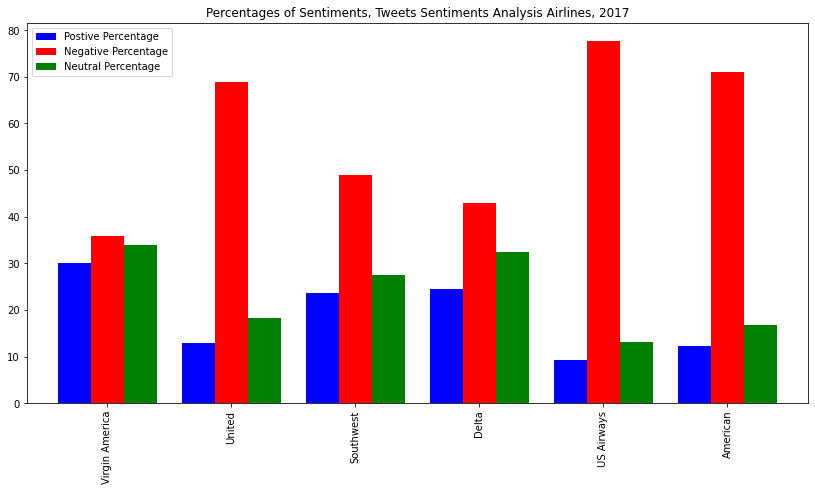

In [37]:
import matplotlib.pyplot as plt
import matplotlib.style
%matplotlib inline
import matplotlib.style
from matplotlib.pyplot import subplots

fig, ax = subplots()
my_colors =['blue','red','green']
my_series.plot(kind='bar', stacked=False, ax=ax, color=my_colors, figsize=(14, 7), width=0.8)
ax.legend(["Postive Percentage","Negative Percentage","Neutral Percentage"])
plt.title("Percentages of Sentiments, Tweets Sentiments Analysis Airlines, 2017")
plt.show()

In [38]:
positive_sentiment_words = ''
negative_sentiment_words = ''
neutral_sentiment_words = ''
neutral = df[df.airline_sentiment == 0]
positive = df[df.airline_sentiment ==1]
negative = df[df.airline_sentiment ==-1]

In [39]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
from wordcloud import WordCloud,STOPWORDS

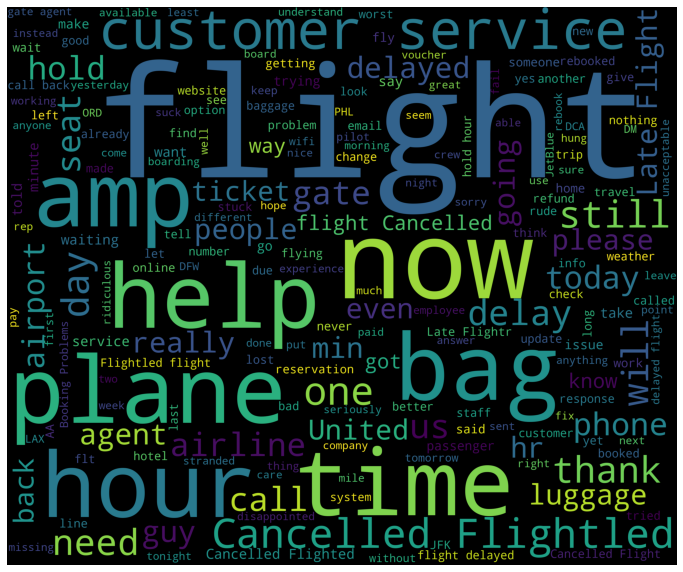

In [41]:
new_df=df[df['airline_sentiment']=='negative']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

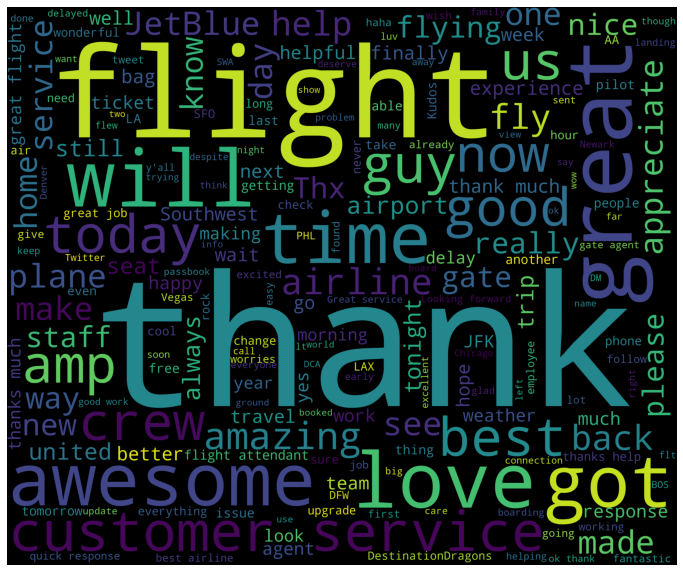

In [42]:
new_df=df[df['airline_sentiment']=='positive']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [43]:
def freq(str): 
    str = str.split()          
    str2 = [] 
    for i in str:              
          if i not in str2: 
              str2.append(i)              
    for i in range(0, len(str2)): 
        if(str.count(str2[i])>50): 
            print('Frequency of', str2[i], 'is :', str.count(str2[i]))
        
print(freq(cleaned_word))

Frequency of to is : 923
Frequency of the is : 924
Frequency of time is : 59
Frequency of I is : 574
Frequency of fly is : 54
Frequency of this is : 143
Frequency of :) is : 96
Frequency of it is : 166
Frequency of was is : 226
Frequency of and is : 416
Frequency of an is : 74
Frequency of good is : 75
Frequency of so is : 163
Frequency of much is : 54
Frequency of is is : 219
Frequency of a is : 501
Frequency of great is : 144
Frequency of my is : 320
Frequency of &amp; is : 77
Frequency of on is : 327
Frequency of I'm is : 67
Frequency of flying is : 59
Frequency of your is : 212
Frequency of all is : 92
Frequency of from is : 124
Frequency of Thanks! is : 69
Frequency of for is : 658
Frequency of flight is : 263
Frequency of but is : 91
Frequency of you is : 509
Frequency of would is : 56
Frequency of be is : 135
Frequency of with is : 195
Frequency of you. is : 77
Frequency of love is : 85
Frequency of You is : 62
Frequency of are is : 120
Frequency of of is : 236
Frequency of that

In [44]:
def plot_for_each_airline(airline_name):
        airline_data=df[df['airline']==airline_name]
        sentiment=airline_data['airline_sentiment'].value_counts()
        label=['Negative','Neutral','Positive']
        index = np.arange(len(label))
        
        plt.bar(index,sentiment)
        plt.xticks(index,label,rotation=45)
        plt.ylabel('Sentimen Count')
        plt.xlabel('Sentiment')
        plt.title(airline_name)

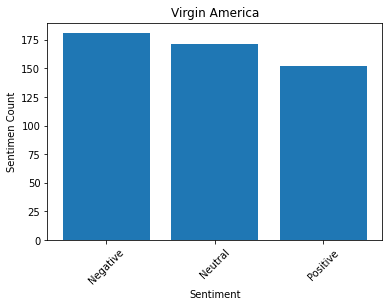

In [45]:
plot_for_each_airline("Virgin America")

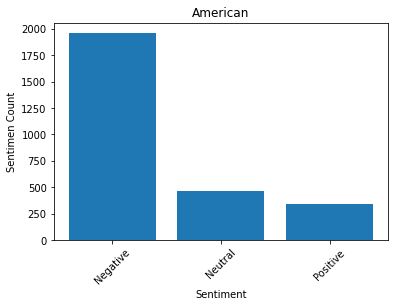

In [46]:
plot_for_each_airline("American")


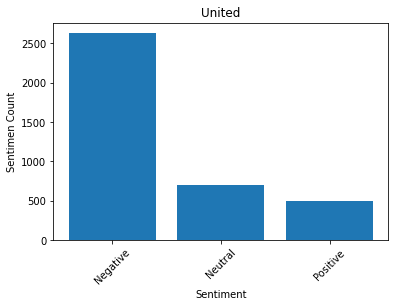

In [47]:
plot_for_each_airline("United")

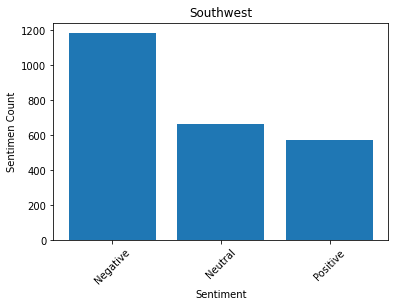

In [48]:
plot_for_each_airline("Southwest")

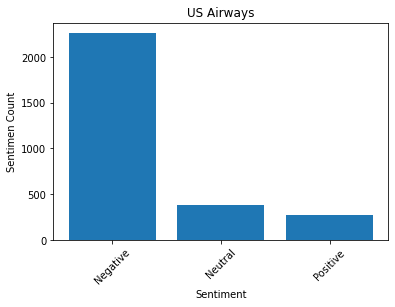

In [49]:
plot_for_each_airline("US Airways")

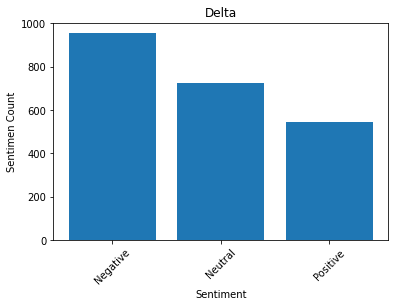

In [50]:
plot_for_each_airline("Delta")

In [48]:
date = df.reset_index()
#convert the Date column to pandas datetime
date.tweet_created = pd.to_datetime(date.tweet_created)
#Reduce the dates in the date column to only the date and no time stamp using the 'dt.date' method
date.tweet_created = date.tweet_created.dt.date
date.tweet_created.head()
df = date
day_df = df.groupby(['tweet_created','airline','airline_sentiment']).size()
# day_df = day_df.reset_index()
day_df

tweet_created  airline         airline_sentiment
2015-02-16     Delta           negative               1
                               neutral                1
               United          negative               2
2015-02-17     Delta           negative             108
                               neutral               86
                                                   ... 
2015-02-24     United          neutral               49
                               positive              25
               Virgin America  negative              10
                               neutral                6
                               positive              13
Length: 136, dtype: int64

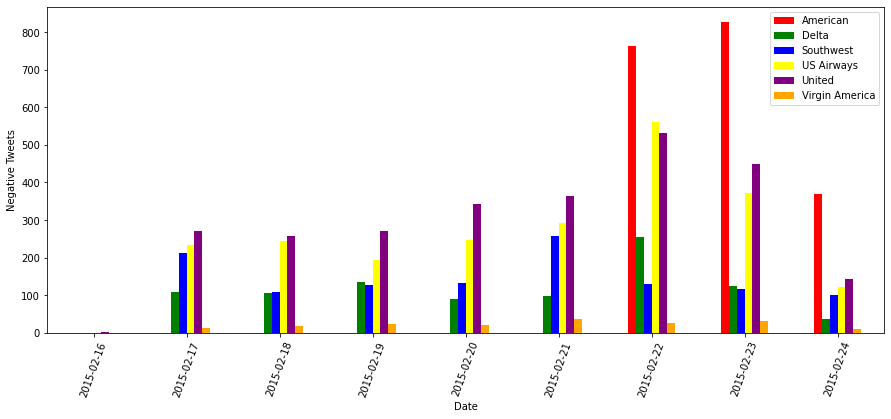

In [49]:
day_df = day_df.loc(axis=0)[:,:,'negative']

#groupby and plot data
ax2 = day_df.groupby(['tweet_created','airline']).sum().unstack().plot(kind = 'bar', color=['red', 'green', 'blue','yellow','purple','orange'], figsize = (15,6), rot = 70)
labels = ['American','Delta','Southwest','US Airways','United','Virgin America']
ax2.legend(labels = labels)
ax2.set_xlabel('Date')
ax2.set_ylabel('Negative Tweets')
plt.show()

In [50]:
import nltk
stopword_list=nltk.corpus.stopwords.words('english')
len(stopword_list)

179

In [51]:
stopword_list.remove('no')

In [52]:
stopword_list.remove('not')

In [53]:
! pip install contractions

In [54]:
import contractions
def con(text):
  expand= contractions.fix(text)
  return expand
con("You can't expand I think")

'You can not expand I think'

In [55]:
import re
def remove_sp(text):
  pattern= r'[^A-Za-z0-9\s]'
  text= re.sub(pattern,'',text)
  return text


In [56]:
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer=ToktokTokenizer()

In [57]:
def remove_stopwords(text):
  tokens=tokenizer.tokenize(text)
  tokens=[token.strip() for token in tokens]
  filtered_tokens =[token for token in tokens if token not in stopword_list]
  filtered_text= ' '.join(filtered_tokens)
  return filtered_text

In [58]:
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

In [59]:
df.columns

Index(['index', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline', 'name',
       'text', 'tweet_created', 'tweet_location', 'user_timezone'],
      dtype='object')

In [60]:
df.head()

,index,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,text,tweet_created,tweet_location,user_timezone
0,0,neutral,1.0000,Nan,Nan,Virgin America,cairdin,@VirginAmerica What @dhepburn said.,2015-02-24,"Boston, MA",Eastern Time (US & Canada)
1,1,positive,0.3486,Nan,0,Virgin America,jnardino,@VirginAmerica plus you've added commercials t...,2015-02-24,"Boston, MA",Pacific Time (US & Canada)
2,2,neutral,0.6837,Nan,Nan,Virgin America,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...,2015-02-24,Lets Play,Central Time (US & Canada)
3,3,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,@VirginAmerica it's really aggressive to blast...,2015-02-24,"Boston, MA",Pacific Time (US & Canada)
4,4,negative,1.0000,Can't Tell,1,Virgin America,jnardino,@VirginAmerica and it's a really big bad thing...,2015-02-24,"Boston, MA",Pacific Time (US & Canada)


In [61]:
df.text= df.text.apply(lambda x:x.lower())

In [62]:

df.text= df.text.apply(remove_sp)

df.text= df.text.apply(con)

df.text= df.text.apply(remove_stopwords)

df.text=df.text.apply(remove_punctuation)



In [63]:
b = df.iloc[7]['text']

In [64]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [65]:
vs =  SentimentIntensityAnalyzer()

In [66]:
vs.polarity_scores(b)['compound']

0.1458

In [67]:
df['compound_pred'] = df['text'].apply(lambda x: vs.polarity_scores(x)['compound'])

In [68]:
df.head()

,index,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,text,tweet_created,tweet_location,user_timezone,compound_pred
0,0,neutral,1.0000,Nan,Nan,Virgin America,cairdin,virginamerica dhepburn said,2015-02-24,"Boston, MA",Eastern Time (US & Canada),0.0000
1,1,positive,0.3486,Nan,0,Virgin America,jnardino,virginamerica plus added commercials experienc...,2015-02-24,"Boston, MA",Pacific Time (US & Canada),0.0000
2,2,neutral,0.6837,Nan,Nan,Virgin America,yvonnalynn,virginamerica not today must mean need take an...,2015-02-24,Lets Play,Central Time (US & Canada),0.0000
3,3,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,virginamerica really aggressive blast obnoxiou...,2015-02-24,"Boston, MA",Pacific Time (US & Canada),-0.3306
4,4,negative,1.0000,Can't Tell,1,Virgin America,jnardino,virginamerica really big bad thing,2015-02-24,"Boston, MA",Pacific Time (US & Canada),-0.5829


In [69]:
df[df['compound_pred'] == 0]

,index,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,text,tweet_created,tweet_location,user_timezone,compound_pred
0,0,neutral,1.0000,Nan,Nan,Virgin America,cairdin,virginamerica dhepburn said,2015-02-24,"Boston, MA",Eastern Time (US & Canada),0.0
1,1,positive,0.3486,Nan,0,Virgin America,jnardino,virginamerica plus added commercials experienc...,2015-02-24,"Boston, MA",Pacific Time (US & Canada),0.0
2,2,neutral,0.6837,Nan,Nan,Virgin America,yvonnalynn,virginamerica not today must mean need take an...,2015-02-24,Lets Play,Central Time (US & Canada),0.0
18,18,positive,1.0000,Nan,Nan,Virgin America,thebrandiray,flying virginamerica,2015-02-24,Somewhere celebrating life.,Atlantic Time (Canada),0.0
20,20,negative,0.6705,Can't Tell,0.3614,Virgin America,MISSGJ,virginamerica first fares may three times carr...,2015-02-24,"Boston, MA",NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
14613,14613,negative,1.0000,Customer Service Issue,0.7255,American,kiabeveridge,americanair used call back feature operator re...,2015-02-22,Chicago,Mountain Time (US & Canada),0.0
14620,14620,negative,1.0000,Customer Service Issue,1,American,KCBobolz,americanair wait 2 hrs cs call back flt cxldpr...,2015-02-22,"Milwaukee County, Wisconsin",Central Time (US & Canada),0.0
14624,14624,negative,1.0000,Can't Tell,1,American,yourlama,americanair call chairman call emerald today c...,2015-02-22,"Boston, MA",NaN,0.0
14629,14629,negative,1.0000,Customer Service Issue,1,American,jontgreen89,americanair change flight phone system keeps t...,2015-02-22,"Waco, TX",Central Time (US & Canada),0.0


In [70]:
#1 to 1
# CS >=0.05  = Positive
# CS >-0.05 and CS <0.05 = Neutral
# CS <=-0.05 = Negative

In [71]:
df['compound_pred'] = df['text'].apply(lambda x: vs.polarity_scores(x)['compound'])

In [72]:
i=0
vader_sentiment = [ ]

while(i<len(df)):
    if ((df.iloc[i]['compound_pred'] >= 0.05)):
        vader_sentiment.append('positive')
        i = i+1
    elif ((df.iloc[i]['compound_pred'] > -0.05) & (df.iloc[i]['compound_pred'] < 0.05)):
        vader_sentiment.append('neutral')
        i = i+1
    elif ((df.iloc[i]['compound_pred'] <= -0.05)):
        vader_sentiment.append('negative')
        i = i+1

In [73]:
df['pred'] = vader_sentiment

In [74]:
df['vader_sentiment_labels'] = vader_sentiment

In [75]:
df['actual_label'] = df['airline_sentiment'].map({'positive': 1, 'neutral': 0, 'negative':-1})
df['predicted_label'] = df['vader_sentiment_labels'].map({'positive': 1, 'neutral': 0, 'negative':-1})

In [76]:
df.head()

,index,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,text,tweet_created,tweet_location,user_timezone,compound_pred,pred,vader_sentiment_labels,actual_label,predicted_label
0,0,neutral,1.0000,Nan,Nan,Virgin America,cairdin,virginamerica dhepburn said,2015-02-24,"Boston, MA",Eastern Time (US & Canada),0.0000,neutral,neutral,0,0
1,1,positive,0.3486,Nan,0,Virgin America,jnardino,virginamerica plus added commercials experienc...,2015-02-24,"Boston, MA",Pacific Time (US & Canada),0.0000,neutral,neutral,1,0
2,2,neutral,0.6837,Nan,Nan,Virgin America,yvonnalynn,virginamerica not today must mean need take an...,2015-02-24,Lets Play,Central Time (US & Canada),0.0000,neutral,neutral,0,0
3,3,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,virginamerica really aggressive blast obnoxiou...,2015-02-24,"Boston, MA",Pacific Time (US & Canada),-0.3306,negative,negative,-1,-1
4,4,negative,1.0000,Can't Tell,1,Virgin America,jnardino,virginamerica really big bad thing,2015-02-24,"Boston, MA",Pacific Time (US & Canada),-0.5829,negative,negative,-1,-1


In [77]:
# Evaluation 
from sklearn.metrics import accuracy_score,confusion_matrix

In [78]:
y_act = df['actual_label'].values
y_pred = df['predicted_label'].values

In [79]:
accuracy_score(y_act, y_pred)

0.4790983606557377

In [80]:
confusion_matrix(df['airline_sentiment'],df['pred'])

array([[3871, 1489, 3818],
       [ 355, 1046, 1698],
       [  91,  175, 2097]])

In [81]:
# Method 2- Sklearn Library
df

,index,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,text,tweet_created,tweet_location,user_timezone,compound_pred,pred,vader_sentiment_labels,actual_label,predicted_label
0,0,neutral,1.0000,Nan,Nan,Virgin America,cairdin,virginamerica dhepburn said,2015-02-24,"Boston, MA",Eastern Time (US & Canada),0.0000,neutral,neutral,0,0
1,1,positive,0.3486,Nan,0,Virgin America,jnardino,virginamerica plus added commercials experienc...,2015-02-24,"Boston, MA",Pacific Time (US & Canada),0.0000,neutral,neutral,1,0
2,2,neutral,0.6837,Nan,Nan,Virgin America,yvonnalynn,virginamerica not today must mean need take an...,2015-02-24,Lets Play,Central Time (US & Canada),0.0000,neutral,neutral,0,0
3,3,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,virginamerica really aggressive blast obnoxiou...,2015-02-24,"Boston, MA",Pacific Time (US & Canada),-0.3306,negative,negative,-1,-1
4,4,negative,1.0000,Can't Tell,1,Virgin America,jnardino,virginamerica really big bad thing,2015-02-24,"Boston, MA",Pacific Time (US & Canada),-0.5829,negative,negative,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,14635,positive,0.3487,Nan,0,American,KristenReenders,americanair thank got different flight chicago,2015-02-22,"Boston, MA",NaN,0.3612,positive,positive,1,1
14636,14636,negative,1.0000,Customer Service Issue,1,American,itsropes,americanair leaving 20 minutes late flight no ...,2015-02-22,Texas,NaN,-0.4043,negative,negative,-1,-1
14637,14637,neutral,1.0000,Nan,Nan,American,sanyabun,americanair please bring american airlines bla...,2015-02-22,"Nigeria,lagos",NaN,0.3182,positive,positive,0,1
14638,14638,negative,1.0000,Customer Service Issue,0.6659,American,SraJackson,americanair money change flight not answer pho...,2015-02-22,New Jersey,Eastern Time (US & Canada),0.3818,positive,positive,-1,1


In [82]:
df.columns

Index(['index', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline', 'name',
       'text', 'tweet_created', 'tweet_location', 'user_timezone',
       'compound_pred', 'pred', 'vader_sentiment_labels', 'actual_label',
       'predicted_label'],
      dtype='object')

In [83]:
x = df.iloc[:,5].values
y = df.iloc[:,0].values

In [84]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=0)

In [85]:
print(x_train.shape)
print(x_test.shape)

(10980,)
(3660,)


In [86]:
import numpy as np
np.unique(y_train,return_counts=True)

(array([    0,     1,     2, ..., 14636, 14637, 14638]),
 array([1, 1, 1, ..., 1, 1, 1]))

In [87]:
np.unique(y_test,return_counts=True)

(array([    8,     9,    12, ..., 14625, 14634, 14639]),
 array([1, 1, 1, ..., 1, 1, 1]))

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
x_train,x_test,y_train,y_test = train_test_split(df["text"],df["airline_sentiment"], test_size = 0.2, random_state = 10)
print("train tuples",x_train.shape)
print("test tuples",x_test.shape)
print("train labels",y_train.shape)
print("test labels",y_test.shape)
vect = CountVectorizer()
vect.fit(x_train)
x_train_df = vect.transform(x_train)
x_test_df = vect.transform(x_test)

train tuples (11712,)
test tuples (2928,)
train labels (11712,)
test labels (2928,)


In [90]:
final = Pipeline([('vect',TfidfVectorizer()),
                  ('model',SVC())])


In [91]:
final.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('model',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', de

In [92]:
y_pred = final.predict(x_test)

In [93]:
accuracy_score(y_pred,y_test)

0.780396174863388

In [94]:
confusion_matrix(y_pred,y_test)

array([[1697,  340,  133],
       [  55,  298,   44],
       [  29,   42,  290]])

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
x_train,x_test,y_train,y_test = train_test_split(df["text"],df["airline_sentiment"], test_size = 0.2, random_state = 10)
print("train tuples",x_train.shape)
print("test tuples",x_test.shape)
print("train labels",y_train.shape)
print("test labels",y_test.shape)
vect = CountVectorizer()
vect.fit(x_train)
x_train_df = vect.transform(x_train)
x_test_df = vect.transform(x_test)

train tuples (11712,)
test tuples (2928,)
train labels (11712,)
test labels (2928,)


In [96]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(x_train_df,y_train)
result=model.predict(x_test_df)

In [97]:
print("Accuracy Score:",accuracy_score(y_test,result))


Accuracy Score: 0.7595628415300546


In [98]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(x_train_df,y_train)
result=clf.predict(x_test_df)

In [99]:
print("Accuracy Score:",accuracy_score(y_test,result))


Accuracy Score: 0.7783469945355191


In [100]:
# Therefore the model has a maximum accuracy of 78.03% followed by 77.83% and 75.95% . 